In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype, Normalize, RandomAffine, RandomHorizontalFlip, RandomCrop

from matplotlib import pyplot as plt
import numpy as np
import time
from datetime import datetime 

In [7]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [8]:
train_transforms = transforms.Compose([
    ToImage(), # to torch.Image uint8
    ToDtype(torch.float32, scale=True), # [0, 255] -> [0, 1] & uint8 -> float32
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize after scale
    RandomAffine(
      degrees=10,
      translate=(0.15, 0.15),
      scale=(0.9, 1.1),
      shear=10
    ),
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
  ToImage(),
  ToDtype(torch.float32, scale=True),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [9]:
trainD = datasets.CIFAR10(root="data", train=True, transform=train_transforms, download=True)
testD = datasets.CIFAR10(root="data", train=False, transform=test_transforms, download=True)

In [10]:
BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [11]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.labels = {
      0: "airplane",  
      1: "automobile", 
      2: "bird",
      3: "cat",
      4: "deer",
      5: "dog",
      6: "frog",
      7: "horse",
      8: "ship",
      9: "truck"
    }
    self.model = nn.Sequential(
      nn.Conv2d(3, 64, 3, padding=1), # 32x32x64
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Conv2d(64, 128, 3), # 29x29x128
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 14x14x128

      nn.Conv2d(128, 256, 3, padding=1), # 14x14x256
      nn.BatchNorm2d(256),
      nn.ReLU(),

      nn.Conv2d(256, 216, 5), # 10x10x216 
      nn.BatchNorm2d(216),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 5x5x216

      nn.Flatten(),
      nn.Linear(5*5*216, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(512, 100)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [12]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if (batch_i % 50 < 1) or (batch_i == len(dataloader) - 1):
      print(f"Batch {batch_i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")


def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(model, epochs: int):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  start_time = datetime.now()

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "cifar10_weights.pth")
  print("\nDone!\nWeights saved to 'cifar10_weights.pth'")
  print(f"Peak Accuracy: {max(accuracies):.2f}% @ Epoch {accuracies.index(max(accuracies))+1}")
  print(f"Time spent training: {(datetime.now() - start_time).total_seconds():.2f}s")
  return accuracies, losses


In [13]:
EPOCHS = 50
model = Cifar().to(DEVICE)

acc, loss = fit(model, EPOCHS)


Starting...

Epoch 1
Batch 1/196, Loss: 4.7111
Batch 51/196, Loss: 1.6257
Batch 101/196, Loss: 1.3640
Batch 151/196, Loss: 1.3162
Batch 196/196, Loss: 1.1799
TEST, Accuracy: 58.08%, Loss: 1.1727

Epoch 2
Batch 1/196, Loss: 1.3013
Batch 51/196, Loss: 1.2994
Batch 101/196, Loss: 1.2025
Batch 151/196, Loss: 1.1015
Batch 196/196, Loss: 1.0730
TEST, Accuracy: 65.53%, Loss: 0.9862

Epoch 3
Batch 1/196, Loss: 1.0802
Batch 51/196, Loss: 1.0858
Batch 101/196, Loss: 0.9904
Batch 151/196, Loss: 1.0244
Batch 196/196, Loss: 1.0107
TEST, Accuracy: 65.47%, Loss: 1.0069

Epoch 4
Batch 1/196, Loss: 0.9083
Batch 51/196, Loss: 0.8845
Batch 101/196, Loss: 0.8766
Batch 151/196, Loss: 0.9068
Batch 196/196, Loss: 0.6661
TEST, Accuracy: 72.42%, Loss: 0.7986

Epoch 5
Batch 1/196, Loss: 0.9023
Batch 51/196, Loss: 0.8167
Batch 101/196, Loss: 0.7011
Batch 151/196, Loss: 0.8125
Batch 196/196, Loss: 0.8196
TEST, Accuracy: 76.67%, Loss: 0.6743

Epoch 6
Batch 1/196, Loss: 0.7886
Batch 51/196, Loss: 0.7753
Batch 101/1

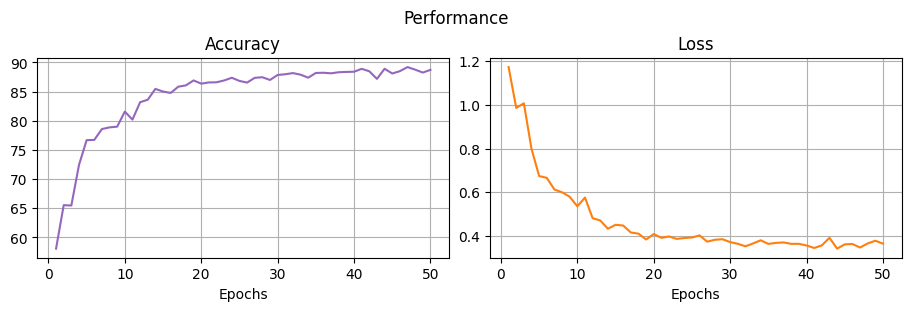

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 3), layout="constrained")
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1, ax2 = axs[0], axs[1]

ax1.plot(epochs, acc, "tab:purple")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.grid(True)

ax2.plot(epochs, loss, "tab:orange")
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.grid(True)

plt.savefig(f"performance_{int(time.time())}")

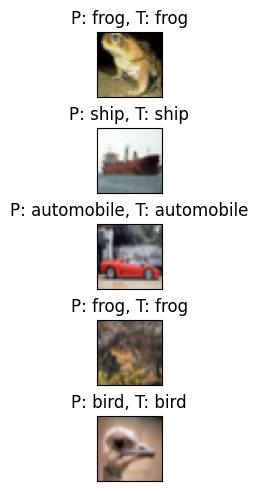

In [16]:
def predict(model):
  model.eval()
  fig, axs = plt.subplots(5, 1, layout="constrained")

  for i in range(5):
    X, label = testD[np.random.randint(len(testD))] # tensor image, label
    
    unnorm = Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])
    img = unnorm(X)
    axs[i].imshow(img.permute(1, 2, 0))

    X = X.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
      pred = model(X).argmax(dim=1).item()
    axs[i].set_title(f"P: {model.labels[pred]}, T: {model.labels[label]}") 
    axs[i].yaxis.set_visible(False)
    axs[i].xaxis.set_visible(False)
  
  plt.show()
  

predict(model)
